In [1]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

#alhindi
al = pd.read_csv('climatedataset2.csv', encoding='utf-8')
#zhijing
zh = pd.read_csv('climate_challenge.csv', encoding='utf-8')

In [2]:
flicc_map = {
            #zhijing:
            'intentional':'cherry picking',
            'equivocation':'contradictory',
            'fallacy of credibility': 'fake experts',
            'false dilemma':'false choice',
            'deductive fallacy': 'logical fallacies',
            'red herring': 'fallacy of relevance',
            'false causality': 'slothful induction',
            'fallacy of extension':'straw man',
            'faulty generalization':'hasty generalization',
            #alhindi:
            'false cause': 'oversimplification',
            'post hoc': 'oversimplification',
            'causal oversimplification':'oversimplification',
            'vagueness':'ambiguity',
            'false authority':'fake experts',
            'fallacy of relevance':'red herring',
            'hasty generalization': 'faulty generalization',
            'evading the burden of proof': 'evading burden of proof'}

al['label'] = al['label'].apply(lambda x: flicc_map.get(x) if x in flicc_map else x)
zh = zh.rename(columns={'logical_fallacies':'label'})
zh['label'] = zh['label'].apply(lambda x: flicc_map.get(x) if x in flicc_map else x)

al = al.rename(columns={'fact_checked_segment':'source_article'})
al = al.drop(['comment_by_fact-checker'], axis=1)
al = al[['source_article', 'label', 'split']]
al['dataset'] = 'alhindi'
zh = zh.drop(['original_url', 'Unnamed: 0'], axis=1)
zh['dataset'] = 'zhijing'

total datapoints:  685
total nan values:  2


Text(0.5, 1.0, 'Alhindi et al. (2022) \n\n685 records, 2 nan\n 10 labels, ~50,30,20 train, val, test')

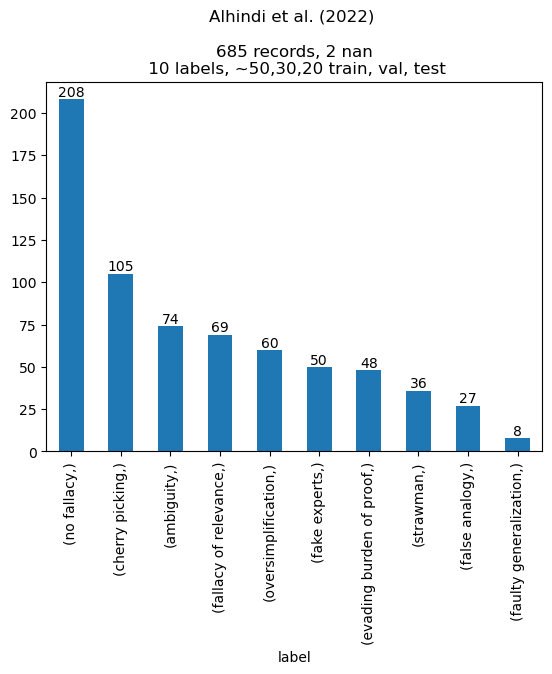

In [3]:
print('total datapoints: ',al.value_counts('label').sum())
print('total nan values: ', al.isna().sum().sum())
ax = al.value_counts(['label'], normalize=False).plot(kind='bar')
ax.bar_label(ax.containers[0])
ax.set_title('Alhindi et al. (2022) \n\n685 records, 2 nan\n 10 labels, ~50,30,20 train, val, test')

total datapoints:  1351
total nan values:  39


Text(0.5, 1.0, 'Jin et al. (2022) \n\n1,351 records, 39 nan\n 13 labels, ~50,30,20 train, val, test')

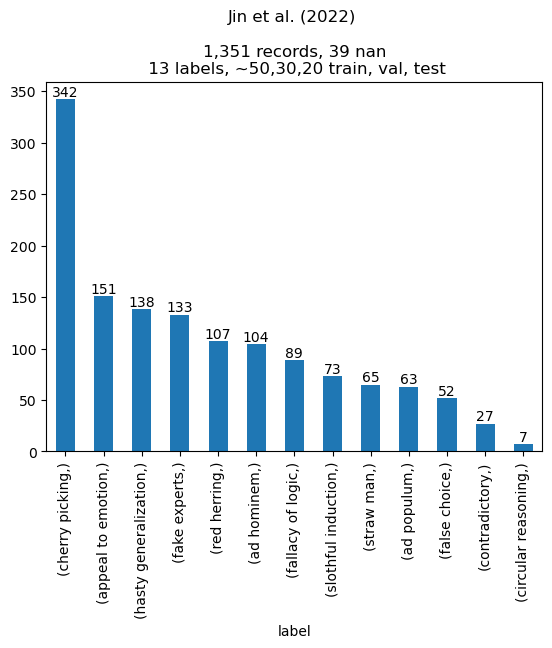

In [4]:
print('total datapoints: ', zh.value_counts('label').sum())
print('total nan values: ', zh.isna().sum().sum())
ax = zh.value_counts(['label'], normalize=False).plot(kind='bar')
ax.bar_label(ax.containers[0])
ax.set_title('Jin et al. (2022) \n\n1,351 records, 39 nan\n 13 labels, ~50,30,20 train, val, test')

In [5]:
al = al.dropna()
zh = zh.dropna()

print(f"total datapoints zhijing: {zh.value_counts('label').sum()} \ntotal datapoints alhindi: {al.value_counts('label').sum()}")

total datapoints zhijing: 1312 
total datapoints alhindi: 683


In [6]:
fallacies = ['ad hominem',
            'ambiguity',
            'anecdote',
            'blowfish',
            'bulk fake experts',
            'cherry picking',
            'contradictory',
            'conspiracy theory',
            'fake debate',
            'fake experts',
            'false analogy',
            'false choice',
            'false equivalence (apples vs. oranges)',
            'immune to evidence',
            'impossible expectations',
            'logical fallacies',
            'magnified minority',
            'misrepresentation',
            'moving goalposts',
            'nefarious intent',
            'overriding suspicion',
            'oversimplification',
            'persecuted victim',
            'quote mining',
            're-interpreting randomness',
            'red herring',
            'single cause',
            'slippery slope',
            'slothful induction',
            'something must be wrong',
            'straw man',
            'no fallacy']

# drop rows where the 'label' column not in the 'fallacies' 
al = al[al['label'].isin(fallacies)]
zh = zh[zh['label'].isin(fallacies)]

print(f"total datapoints zhijing: {zh.value_counts('label').sum()} \ntotal datapoints alhindi: {al.value_counts('label').sum()}")

total datapoints zhijing: 880 
total datapoints alhindi: 522


In [7]:
# merge alhindi, zhijing datasets.
df = pd.concat([al, zh], ignore_index=True)
df.value_counts('label')

label
cherry picking        442
no fallacy            206
fake experts          181
red herring           103
ad hominem             96
ambiguity              74
slothful induction     73
straw man              64
oversimplification     60
false choice           49
contradictory          27
false analogy          27
dtype: int64

In [8]:
# Open John's training examples:
sheet_link =  'https://docs.google.com/spreadsheets/d/1FTha5YU_hqdqJodpA9_mefqv5oETz3nPpO_OEn0GtZc/edit?usp=sharing'

# Extract the Sheet ID, set export format:
sheet_id = sheet_link.split('/d/')[1].split('/edit')[0]
export_format = '/export?gid=16912251&format=csv'

# Construct the CSV download link
csv_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}{export_format}'

# Read the Google Sheet as a pandas DataFrame
jc = pd.read_csv(csv_url)
jc = jc.rename(columns={'Example text of contrarian claim':'source_article', '1st fallacy':'label'})
jc['label'] = jc['label'].str.lower()
jc = jc.drop(['Code'], axis=1)
to_drop = [x for x in jc['label'].unique() if x not in df.value_counts('label').index.to_list()]
jc = jc[~jc['label'].isin(to_drop)]
jc['split'] = 'train'
jc['dataset'] = 'johncook'

# Add dev split in jc dataset, exclude 'false choice' -> only one sample
for idx in jc.query("label != 'false choice'").groupby('label').apply(lambda x: x.sample(n=2, random_state=1)).index:
    jc.loc[idx[1], 'split'] = 'dev'

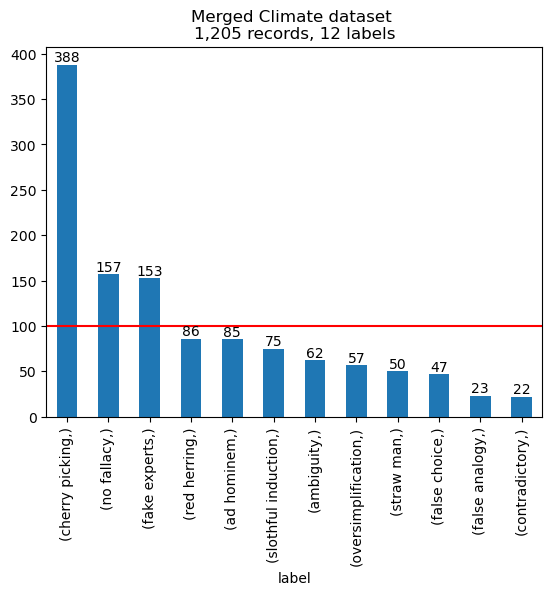

In [10]:
df = pd.concat([df, jc], ignore_index=True)

def remove_quotes(sentence):
    # remove trail/tail quotes and whitespace
    sentence = sentence.replace(u'\u201c', '"').replace(u'\u201d', '"') # replace curly quotes
    pattern = r'^\s*["\']|["\']\s*$'
    return re.sub(pattern, '', sentence)

df['source_article'] = df['source_article'].apply(remove_quotes)    # remove quotes
df = df[~df['source_article'].duplicated()].reset_index(drop=True)                              # remove duplicated articles

ax = df.value_counts(['label'], normalize=False).plot(kind='bar')
ax.bar_label(ax.containers[0])
ax.set_title('Merged Climate dataset \n1,205 records, 12 labels')
plt.axhline(y=100, color='r', linestyle='-')

In [29]:
df

,source_article,label,split,dataset
0,The study is the product of a large group of A...,cherry picking,dev,alhindi
1,"there are alarming stories every day, like las...",cherry picking,dev,alhindi
2,The report confidently claims that when temper...,cherry picking,dev,alhindi
3,In recent decades this warming has been accomp...,cherry picking,dev,alhindi
4,According to a recent National Economic Resear...,cherry picking,dev,alhindi
...,...,...,...,...
1200,Problems with surface measurements are notorio...,slothful induction,dev,johncook
1201,"With these words last December 14, the New Zea...",ad hominem,train,johncook
1202,The US government spends $2.5 billion per year...,ad hominem,train,johncook
1203,Radical environmentalists even tried to blame ...,ad hominem,dev,johncook


In [59]:
# Save the data as JSONL
# "prompt": "<prompt text>", "completion": "<ideal generated text>"
data = list()
for i in df.index:

    if df.loc[i, 'split'] == 'train':   
        data.append({
            'prompt': f"{df.loc[i, 'source_article']} ->",
            'completion': f" {df.loc[i, 'label']} END"})

with open("train.jsonl", 'w') as f:
    for item in data:
        f.write(json.dumps(item) + "\n")


data = list()
for i in df.index:

    if df.loc[i, 'split'] == 'dev':  
        data.append({
            'prompt': f"{df.loc[i, 'source_article']} ->",
            'completion': f" {df.loc[i, 'label']} END"})

with open("eval.jsonl", 'w') as f:
    for item in data:
        f.write(json.dumps(item) + "\n")

In [60]:
data = list()
for i in df.index:

    if df.loc[i, 'split'] == 'test' and df.loc[i, 'dataset'] == 'alhindi':   
        data.append({
            'prompt': f"{df.loc[i, 'source_article']} ->",
            'completion': f" {df.loc[i, 'label']} END"})

with open("alhindi.jsonl", 'w') as f:
    for item in data:
        f.write(json.dumps(item) + "\n")


data = list()
for i in df.index:

    if df.loc[i, 'split'] == 'test' and df.loc[i, 'dataset'] == 'zhijing':   
        data.append({
            'prompt': f"{df.loc[i, 'source_article']} ->",
            'completion': f" {df.loc[i, 'label']} END"})

with open("zhijing.jsonl", 'w') as f:
    for item in data:
        f.write(json.dumps(item) + "\n")